# CycleGAN

In [ ]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

In [ ]:
class CycleGAN:
  def __init__(self):
    self.lr = 0.001
    self.decay = 8e-7

  def lencoder(self, inputs, filters=16, k_size=3, strides=2, activation='relu', i_norm=True):
    x = inputs
    if i_norm:
      x = InstanceNormalization(axis=3)(x)
    if activation=='relu':
      x = layers.Activation('relu')(x)
    else:
      x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(filters, k_size, strides=strides, padding='same')(x)
    return x
  
  def ldecoder(self,inputs, paired_inputs, filters=16, k_size=3, strides=2, activation='relu', i_norm=True):
    x = inputs
    if i_norm:
      x = InstanceNormalization(axis=3)(x)
    if activation=='relu':
      x = layers.Activation('relu')(x)
    else:
      x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(filters, k_size, strides=strides, padding='same')(x)
    x = layers.Concatenate()([x, paired_inputs])
    return x

  def generate_generator(self, input_shape, output_shape=None, name='Generator'):
    channels = output_shape[-1]
    inputs = layers.Input(shape=input_shape)
    e1 = self.lencoder(inputs, filters=32, k_size=3, activation='leaky_relu', strides=1)
    e2 = self.lencoder(e1, filters=64, k_size=3, activation='leaky_relu')
    e3 = self.lencoder(e2, filters=128, k_size=3, activation='leaky_relu')
    e4 = self.lencoder(e3, filters=256, k_size=3, activation='leaky_relu')
    d1 = self.ldecoder(e4, e3, filters=128, k_size=3)
    d2 = self.ldecoder(d1, e2, filters=64, k_size=3)
    d3 = self.ldecoder(d2, e1, filters=32, k_size=3)
    outputs = layers.Conv2DTranspose(channels, kernel_size=3, strides=1, padding='same', activation='sigmoid')(d3)
    gen = keras.Model(inputs, outputs, name=name)
    return gen

  def generate_discriminator(self, input_shape, name='Discriminator'):
    inputs = layers.Input(shape=input_shape)
    x = self.lencoder(inputs, filters=32, k_size=3, activation='leaky_relu', i_norm=False)
    x = self.lencoder(x, filters=64, k_size=3, activation='leaky_relu', i_norm=False)
    x = self.lencoder(x, filters=128, k_size=3, activation='leaky_relu', i_norm=False)
    x = self.lencoder(x, filters=256, k_size=3, activation='leaky_relu', i_norm=False, strides=1)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    dis = keras.Model(inputs, x, name=name)
    return dis

  def generate_cyclegan(self, shapes, source_name = 'source', target_name='target', k_size=3):
    source_shape, target_shape = shapes
    self.gen_t = self.generate_generator(source_shape, output_shape=target_shape, name='Gen_'+target_name)
    self.gen_s = self.generate_generator(target_shape, output_shape=source_shape, name='Gen_'+source_name)
    self.dis_t = self.generate_discriminator(target_shape, name='Dis_'+target_name)
    self.dis_s = self.generate_discriminator(source_shape, name='Dis_'+source_name)
    # Compilamos
    optimizer = optimizers.Adam(self.lr, decay=self.decay)
    self.dis_t.compile(loss='mse', optimizer=optimizer, metrics=['acc'])
    self.dis_s.compile(loss='mse', optimizer=optimizer, metrics=['acc'])
    self.dis_t.trainable = False
    self.dis_s.trainable = False
    # Forward
    source_inputs = layers.Input(shape=source_shape)
    fake_target = self.gen_t(source_inputs)
    preal_target = self.dis_t(fake_target)
    re_source = self.gen_s(fake_target)
    # Backward
    target_inputs = layers.Input(shape=target_shape)
    fake_source = self.gen_s(target_inputs)
    preal_source = self.dis_s(fake_source)
    re_target = self.gen_t(fake_source)

    # Adversarial
    inputs = [source_inputs, target_inputs]
    outputs = [preal_source, preal_target, re_source, re_target]

    self.adv = keras.Model(inputs, outputs, name='Adversarial')
    optimizer = optimizers.Adam(self.lr*0.5, decay=self.decay*0.5)
    loss = ['mse', 'mse', 'mae', 'mae']
    loss_weights = [1., 1., 10., 10.]
    self.adv.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['acc'])
  
  def fit(self, data, batch_size, epochs):
    s_train, t_train, s_test, t_test = data
    target_size = t_train.shape[0]
    source_size = s_train.shape[0]
    n_steps = target_size//batch_size
    for e in range(epochs):
      for i in range(n_steps):
        rand_idx = np.random.randint(0, target_size, size=batch_size)
        real_target = t_train[rand_idx]

        rand_idx = np.random.randint(0, source_size, size=batch_size)
        real_source = s_train[rand_idx]

        fake_target = self.gen_t.predict(real_source)
        y_valid = np.ones([batch_size, 1])
        y_fake = np.zeros([batch_size, 1])
        valid_fake = np.concatenate([y_valid, y_fake])
        x = np.concatenate([real_target, fake_target])
        metrics = self.dis_t.train_on_batch(x, valid_fake) # Metricas
        
        fake_source = self.gen_s.predict(real_target)
        x = np.concatenate([real_source, fake_source])
        metrics = self.dis_s.train_on_batch(x, valid_fake) # Metricas

        # Entrenamiento del adversarial
        x = [real_source, real_target]
        y = [y_valid, y_valid, real_source, real_target]
        metrics = self.adv.train_on_batch(x,y) # Metricas
      
      rand_idx = np.random.randint(0, len(s_test), size=5)
      source = s_test[rand_idx]
      target_real = t_test[rand_idx]
      target_fake = self.gen_t.predict(source)
      print('Epoca',e+1)
      fig, ax = plt.subplots(3,5)
      for i in range(5):
        ax[0,i].imshow(source[i,:,:,0], cmap='gray') 
        ax[1,i].imshow(target_real[i]) 
        ax[2,i].imshow(target_fake[i]) 
      plt.show()

  def get_cifar10_bn_rgb(self):
    (target_train, _), (target_test, _) = cifar10.load_data()
    source_train =  (0.299*target_train[:,:,:,0] + 0.587*target_train[:,:,:,1] + 0.114*target_train[:,:,:,2])
    source_test = (0.299*target_test[:,:,:,0] + 0.587*target_test[:,:,:,1] + 0.114*target_test[:,:,:,2])
    source_train = np.expand_dims(source_train, axis=3)/255
    source_test = np.expand_dims(source_test, axis=3)/255
    return (source_train, target_train/255, source_test, target_test/255)

In [ ]:
cgan = CycleGAN()

In [ ]:
shapes = ((32,32,1), (32,32,3))

cgan.generate_cyclegan(shapes)

In [ ]:
data = cgan.get_cifar10_bn_rgb()

In [ ]:
data[0].shape, data[1].shape

((50000, 32, 32, 1), (50000, 32, 32, 3))

In [ ]:
data[3][0]

array([[[0.61960784, 0.43921569, 0.19215686],
        [0.62352941, 0.43529412, 0.18431373],
        [0.64705882, 0.45490196, 0.2       ],
        ...,
        [0.5372549 , 0.37254902, 0.14117647],
        [0.49411765, 0.35686275, 0.14117647],
        [0.45490196, 0.33333333, 0.12941176]],

       [[0.59607843, 0.43921569, 0.2       ],
        [0.59215686, 0.43137255, 0.15686275],
        [0.62352941, 0.44705882, 0.17647059],
        ...,
        [0.53333333, 0.37254902, 0.12156863],
        [0.49019608, 0.35686275, 0.1254902 ],
        [0.46666667, 0.34509804, 0.13333333]],

       [[0.59215686, 0.43137255, 0.18431373],
        [0.59215686, 0.42745098, 0.12941176],
        [0.61960784, 0.43529412, 0.14117647],
        ...,
        [0.54509804, 0.38431373, 0.13333333],
        [0.50980392, 0.37254902, 0.13333333],
        [0.47058824, 0.34901961, 0.12941176]],

       ...,

       [[0.26666667, 0.48627451, 0.69411765],
        [0.16470588, 0.39215686, 0.58039216],
        [0.12156863, 0

In [ ]:
cgan.fit(data, 128, 30)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cgan.gen_t.predict(data[0][1:2])

array([[[[0.6104408 , 0.6421255 , 0.6248487 ],
         [0.5264358 , 0.6119022 , 0.5541843 ],
         [0.39263016, 0.50869465, 0.4909942 ],
         ...,
         [0.41475934, 0.4544725 , 0.36431405],
         [0.373769  , 0.40724277, 0.32711422],
         [0.323773  , 0.3527552 , 0.2910721 ]],

        [[0.5666391 , 0.6594811 , 0.6069406 ],
         [0.552989  , 0.65369076, 0.5998064 ],
         [0.45950678, 0.6074784 , 0.58852476],
         ...,
         [0.38635913, 0.40096292, 0.31865612],
         [0.31015408, 0.36433488, 0.28637254],
         [0.2739397 , 0.26773083, 0.21755427]],

        [[0.55402565, 0.6479108 , 0.65517956],
         [0.52317107, 0.67908776, 0.6209015 ],
         [0.47113687, 0.62413883, 0.6198562 ],
         ...,
         [0.27751923, 0.35557333, 0.24234614],
         [0.27202278, 0.27491292, 0.19638549],
         [0.24913605, 0.26650572, 0.20290345]],

        ...,

        [[0.6589039 , 0.7133324 , 0.6706244 ],
         [0.63041675, 0.6709539 , 0.6393954 ]

In [ ]:
cgan.adv.summary()

Model: "Adversarial"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 Gen_source (Functional)        (None, 32, 32, 1)    870183      ['Gen_target[0][0]',             
                                                                  'input_24[0][0]']               
                                                                                                  
 Gen_target (Functional)        (None, 32, 32, 3)    870757      ['input_23[0][0]',     

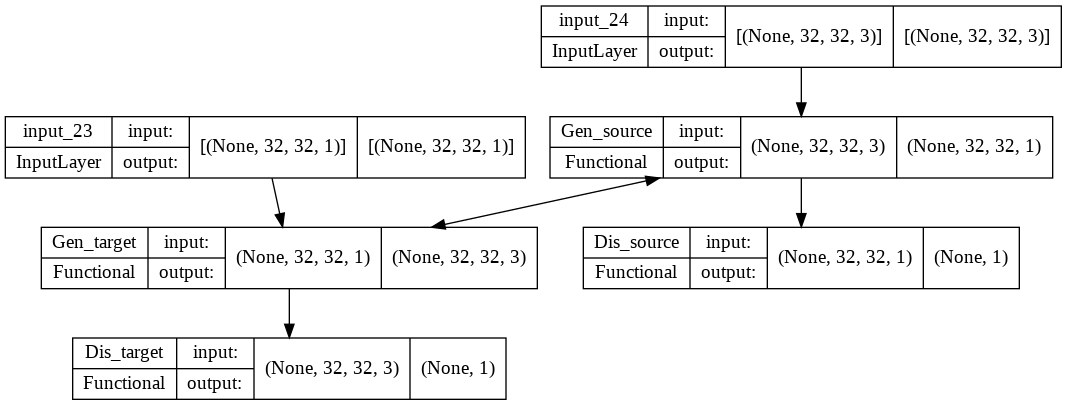

In [ ]:
plot_model(cgan.adv, show_shapes=True)